# About the Project
In this assignment, Kaggle competition called [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview) is used to try CNN learned in the week3 lecture.

***
## Problem Description
In this competition, large number of small pathology images are given. The image size is 96x96 and named with image id. The `train_labels.csv` provides boolean ground truth for each image ids.

Ground truth "positive" label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Outer region is not taken into account when label is assigned. We are required to classify positive/negative against given images.

Dataset size is about 7GB. We may need to consider subsampling of the data to avoid too much computation time required to run learning phase.

***
### Import Libraries

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gc

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, MaxPooling2D

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam, RMSprop
from keras.metrics import AUC
from keras.applications import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras import Model

In [ ]:
! pip install -q kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:43<00:00, 190MB/s]
100% 6.31G/6.31G [00:43<00:00, 156MB/s]


In [ ]:
!ls .

histopathologic-cancer-detection.zip  sample_data


In [ ]:
!unzip histopathologic-cancer-detection.zip > /dev/null 2>&1

#### Set Paths for the Dataset

In [ ]:
!ls .

histopathologic-cancer-detection.zip  sample_submission.csv  train
sample_data			      test		     train_labels.csv


In [ ]:
label_csv_path = "./train_labels.csv"
sample_submission_path = "./sample_submission.csv"
train_img_dir_path = "./train/"
test_img_dir_path = "./test/"

***
## EDA
The number of data is as follows. Data size is about 2 hundred thousand.

In [ ]:
print("training data size: ", len(os.listdir(train_img_dir_path)))
print("test data size: ", len(os.listdir(test_img_dir_path)))

training data size:  220025
test data size:  57458


Data label balance is not bad. If we observe strong biased balance, we need to take it into account.

In [ ]:
label_df = pd.read_csv(label_csv_path)
label_df["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

As the label is associated with id and file path contains id information, we can create combined dataframe by merging them

In [ ]:
df = pd.DataFrame({"path": glob.glob(os.path.join(train_img_dir_path, "*.tif"))})
df["id"] = df["path"].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df = df.merge(label_df, on="id")
df.head()

,path,id,label
0,./train/73298dc242f02f20ef48fcc183ab451a535ca5...,73298dc242f02f20ef48fcc183ab451a535ca51d,0
1,./train/382ccfe0cf677d8dbe57f737425e405f394845...,382ccfe0cf677d8dbe57f737425e405f394845c8,0
2,./train/239a16f73d0bbe2bdfce07dd982e4f9a4a3345...,239a16f73d0bbe2bdfce07dd982e4f9a4a334596,0
3,./train/7b65bc2b474070d07f337988009730a4778aa0...,7b65bc2b474070d07f337988009730a4778aa035,1
4,./train/755c8163c15a3859215b456cf1813c10dbc335...,755c8163c15a3859215b456cf1813c10dbc33590,1


### Visualize Example Image

In [ ]:
n_image = 5

random_positive_indces =  np.random.choice(df[df["label"] == 1].index, size=5)
random_negative_indces =  np.random.choice(df[df["label"] == 0].index, size=5)

In [ ]:
def visualize_images(df, indces):
    fig, ax = plt.subplots(1, n_image, figsize=(20, 4))

    for i, idx in enumerate(indces):
        path = os.path.join(train_img_dir_path, df.iloc[idx]['id']) + ".tif"
        print(i, " \t id:" , idx, "\t path:", path)
        bgr_img = cv2.imread(path)
        b,g,r = cv2.split(bgr_img)
        rgb_img = cv2.merge([r,g,b])

        ax[i].imshow(rgb_img)

    ax[0].set_ylabel('samples', size='large')
    plt.show()

### Positive Example

0  	 id: 128224 	 path: ./train/d3218cc92e5fd7663edb4b61af5d0622b9d5e918.tif
1  	 id: 128784 	 path: ./train/b2ec5a9a70acbb5b15f469e012548f2279e81718.tif
2  	 id: 80557 	 path: ./train/3ccdf28b8edc54fa192fe3782bc8cbbce3e29989.tif
3  	 id: 2121 	 path: ./train/92241a429ae96a3bd4b7b485880a13d31d47707d.tif
4  	 id: 165137 	 path: ./train/b9013d1a30d8b50f369d06be4e7bf28070ebe978.tif


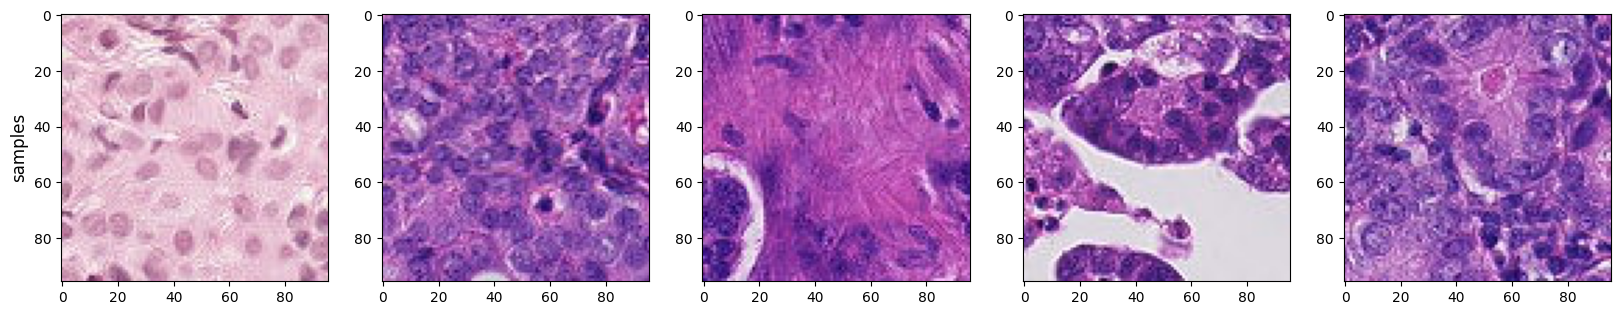

In [ ]:
visualize_images(df, random_positive_indces)

### Negative Example

0  	 id: 87633 	 path: ./train/6f4704d5a7be52216b559b5e70c2221fbe5d18e7.tif
1  	 id: 122009 	 path: ./train/d0f96718a7589aed3946f3a91b9d71937f1d04a6.tif
2  	 id: 57067 	 path: ./train/60a3f535b5a1a64e6712a8180ba2ba50fbc79ac8.tif
3  	 id: 56575 	 path: ./train/235ca63ea667d2e40ff6b9d65b552d10d2064750.tif
4  	 id: 202863 	 path: ./train/678652e130bb9c295e8b9ba39be858883843657d.tif


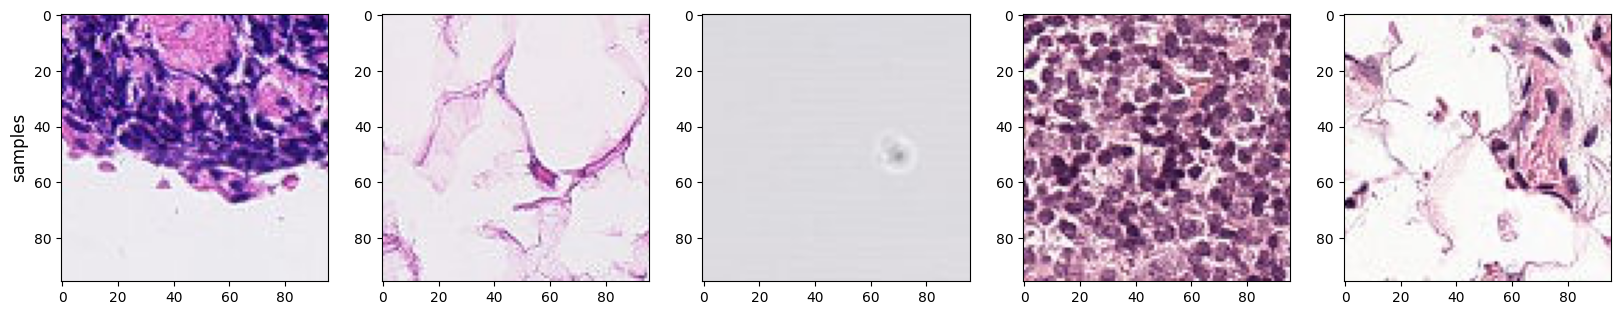

In [ ]:
visualize_images(df, random_negative_indces)

In [ ]:
# Randomly select n indices from the dataframe
n = 3000
random_indices =  np.random.choice(df.shape[0], size=n, replace=False)

# Allocate a numpy array
X = np.zeros([n, 96, 96, 3], dtype=np.uint8)
y = np.squeeze(df['label'].values)[random_indices]

# read images
for i, idx in enumerate(random_indices):
    X[i] = cv2.imread(df.loc[idx, 'path'])

In [ ]:
# seperate positive and negaive sample and get means
pos_samples = X[y == 1]
neg_samples = X[y == 0]

n_smaller= min(len(pos_samples), len(neg_samples))
if len(pos_samples) > len(neg_samples):
    pos_samples = pos_samples[0: n_smaller]
else:
    neg_samples = neg_samples[0: n_smaller]

# means brightness of positive and negative samples
pos_sample_avgs=np.mean(pos_samples, axis=(1,2,3))
neg_sample_avgs=np.mean(neg_samples, axis=(1,2,3))
pos_sample_mins=np.min(pos_samples, axis=(1,2,3))
neg_sample_mins=np.min(neg_samples, axis=(1,2,3))
pos_sample_maxs=np.max(pos_samples, axis=(1,2,3))
neg_sample_maxs=np.max(neg_samples, axis=(1,2,3))

### Plot some statistics
We can see somehow positive output and negative output has different distribution in their mean brightness values. Of course, it is quite difficult to judge only with this information. But there should be a good indicator if we look deeper.

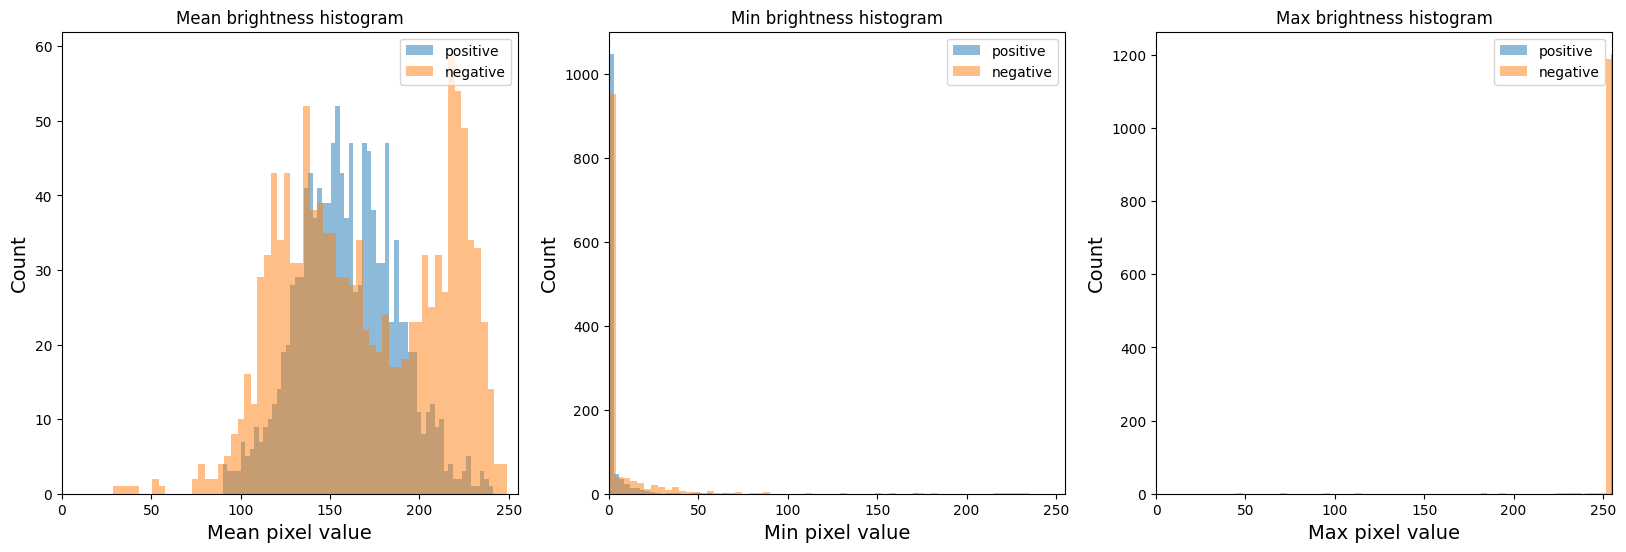

In [ ]:
# Plot mean,min,max brightness histograms for positive and negative samples
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(pos_sample_avgs, bins= 60, alpha=0.5, label="positive")
axs[0].hist(neg_sample_avgs, bins= 60, alpha=0.5, label="negative")
axs[0].set_title("Mean brightness histogram")
axs[0].set_xlabel("Mean pixel value", size=14)
axs[0].set_ylabel("Count", size=14)
axs[0].set_xlim([0, 255])
axs[0].legend(loc='upper right')

axs[1].hist(pos_sample_mins, bins= 60, alpha=0.5, label="positive")
axs[1].hist(neg_sample_mins, bins= 60, alpha=0.5, label="negative")
axs[1].set_title("Min brightness histogram")
axs[1].set_xlabel("Min pixel value", size=14)
axs[1].set_ylabel("Count", size=14)
axs[1].set_xlim([0, 255])
axs[1].legend(loc='upper right')

axs[2].hist(pos_sample_maxs, bins= 60, alpha=0.5, label="positive")
axs[2].hist(neg_sample_maxs, bins= 60, alpha=0.5, label="negative")
axs[2].set_title("Max brightness histogram")
axs[2].set_xlabel("Max pixel value", size=14)
axs[2].set_ylabel("Count", size=14)
axs[2].set_xlim([0, 255])
axs[2].legend(loc='upper right')


***
## Create DNN Model (Baseline)

Firtstly, normal CNN is applied. And then transfer learning is applied.

### Train-ValidationSplit

In [ ]:
# train test split
df_train, df_valid = train_test_split(df, test_size=0.10, random_state=100)
df_train.reset_index(inplace = True)
df_valid.reset_index(inplace = True)

In [ ]:
# Collect garbage to free up memory
del df
gc.collect()

29714

In [ ]:
print(df_train.shape, df_valid.shape)
print(df_train)

(198022, 4) (22003, 4)
         index                                               path  \
0        31636  ./train/f07bd0718ca604a1658bf506bff39ef3f09b54...   
1        90295  ./train/b5100ce961f77a0a20287d2773f6b95ce564e6...   
2        50436  ./train/95f056e90645c0ae703f77da80e1964a88be60...   
3       205697  ./train/1bb7ce584b80eea83e54874dcf6bb0c3d56e9b...   
4       163119  ./train/2744dcd2b9c4ea81f1bd1f9c3b7fe60769afd8...   
...        ...                                                ...   
198017   65615  ./train/00c5d1cbabdce3cec9884a8b75aaf45a2928fb...   
198018   77655  ./train/2d8f19437068aae21f8f60ff13697213cbf113...   
198019  210755  ./train/3a15e4588ced68a47ad32b40cb13d6c7e72219...   
198020   56088  ./train/cfac706320a44ed7761c12f85901414bbb7ad7...   
198021   38408  ./train/b91bec332e77530c52978a6c0ae3bb887b7def...   

                                              id  label  
0       f07bd0718ca604a1658bf506bff39ef3f09b5476      0  
1       b5100ce961f77a0a20287d27

#### Store data for interation
As the dataset is too large, it would be better to store as serialized data so that we don't need to open up images each time we do re-run.

In [ ]:
# Allocate a numpy array
train_X = np.zeros([df_train.shape[0], 96, 96, 3], dtype=np.uint8)
valid_X = np.zeros([df_valid.shape[0], 96, 96, 3], dtype=np.uint8)

# read images
for i, row in df_train.iterrows():
    train_X[i] = cv2.imread(row['path'])
for i, row in df_valid.iterrows():
    valid_X[i] = cv2.imread(row['path'])

np.save("train_X.npy", train_X)
np.save("valid_X.npy", valid_X)

In [ ]:
train_X = np.load("train_X.npy")
valid_X = np.load("valid_X.npy")
train_y = df_train["label"]
valid_y = df_valid["label"]

### Build Model

In [ ]:
# Build CNN model
# Note for model 1 to model 3, I used copied numpy data. I later found this method consumes too much memory.
CNN_model = tf.keras.models.Sequential([
   Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
   Conv2D(32, (3, 3), activation='relu'),
   MaxPooling2D((2, 2)),
   Conv2D(64, (3, 3), activation='relu'),
   Conv2D(64, (3, 3), activation='relu'),
   MaxPooling2D((2, 2)),
   Conv2D(64, (1, 1), activation='relu'),
   Flatten(),
   Dense(64, activation='relu'),
   Dense(64, activation='relu'),
   Dense(1, activation='sigmoid')
])

# Model summary
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 21, 64)        0         
 g2D)                                                 

### Compile and Fit

In [ ]:
# Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000 # total steps = (training size/batchsize) * number of epochs, 200,000/64*3= around 10000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

CNN_model.compile(
    optimizer=Adam(learning_rate= lr_schedule),
    loss='binary_crossentropy',
    metrics=[AUC()]
)

In [ ]:
# # Fit model 1
# datagen = ImageDataGenerator(rescale=1.0 / 255.0)
# train_generator = datagen.flow(train_X, train_y, batch_size=64)
# val_generator = datagen.flow(valid_X, valid_y, batch_size=64)
# mymodel_1.fit(train_generator, validation_data=val_generator, epochs=10, batch_size=64, verbose=2)

In [ ]:
CNN_model_history_auc=     [0.9000, 0.9528, 0.9703, 0.9809, 0.9884, 0.9933, 0.9961, 0.9977]
CNN_model_history_auc_val= [0.9416, 0.9622, 0.9702, 0.9724, 0.9693, 0.9705, 0.9674, 0.9636]

CNN_model_history_loss=         [0.3893, 0.2691, 0.2121, 0.1692, 0.1310, 0.0982, 0.0723, 0.0522]
CNN_model_history_loss_val=     [0.3036, 0.2483, 0.2153, 0.2046, 0.2254, 0.2318, 0.2643, 0.3013]

### Result
It seems that result is not so bad. Seems a bit of room for improvement by minimizing overfitting

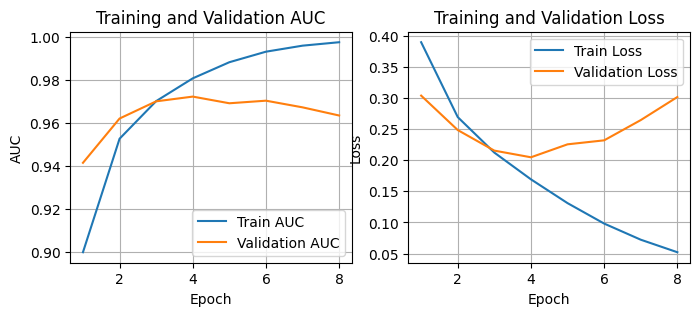

In [ ]:
# Plot training and validation AUC
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
# plt.plot(history.history['auc'], label='Train AUC')
# plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(range(1, 9),CNN_model_history_auc, label='Train AUC')
plt.plot(range(1, 9),CNN_model_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 9),CNN_model_history_loss, label='Train Loss')
plt.plot(range(1, 9),CNN_model_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Collect garbage to free up memory
del CNN_model

gc.collect()

7261

***
## Transfer Learning
Here I used VGG16 as the source of tranfer learning. VGG16 is a bit older DNN architecture dates back to 2014. The model is knows as simple but good prediction result.

In this assignment, I used intermediate later in the vgg net so that I can utilize low level feature extraction from it and then additional training can be done for this specific task.

In [ ]:
 # Load the VGG16
densenet_model = VGG16(weights='imagenet',include_top = False, input_shape=(96, 96, 3))

# Freeze the weights of the layers.
for layer in densenet_model.layers[:-8]:
    layer.trainable = False

# get the last_layer of inception we want to use
last_layer = densenet_model.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)

base_model = Model(inputs=densenet_model.input, outputs=last_layer.output)
base_model.summary()

last layer output shape:  (None, 6, 6, 512)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (M

### Add Layers for This Task

In [ ]:
# Add layers to the model
mymodel_vgg = Sequential([
    base_model,

    Conv2D(16, (3, 3), padding='same', activation='relu'), # keep the width and height
    BatchNormalization(),
    Conv2D(16, (1, 1),activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# Print the model summary
mymodel_vgg.build(input_shape=(None, 96, 96, 3))
mymodel_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 6, 6, 512)         7635264   
                                                                 
 conv2d_12 (Conv2D)          (None, 6, 6, 16)          73744     
                                                                 
 batch_normalization_3 (Bat  (None, 6, 6, 16)          64        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 16)          272       
                                                                 
 batch_normalization_4 (Bat  (None, 6, 6, 16)          64        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 16)         

In [ ]:
#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
mymodel_vgg.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=[AUC()]
)

### Conduct Training

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10

# data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
)

train_generator = datagen.flow(train_X, train_y, batch_size=BATCH_SIZE)

val_generator = datagen.flow(valid_X, valid_y, batch_size=BATCH_SIZE)

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Fit vgg model
vgg_history = mymodel_vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/10
3095/3095 [==============================] - 478s 153ms/step - loss: 0.3144 - auc_3: 0.9342 - val_loss: 0.2987 - val_auc_3: 0.9462
Epoch 2/10
3095/3095 [==============================] - 476s 154ms/step - loss: 0.2489 - auc_3: 0.9583 - val_loss: 0.2354 - val_auc_3: 0.9675
Epoch 3/10
3095/3095 [==============================] - 471s 152ms/step - loss: 0.2238 - auc_3: 0.9661 - val_loss: 0.2194 - val_auc_3: 0.9685
Epoch 4/10
3095/3095 [==============================] - 470s 152ms/step - loss: 0.2076 - auc_3: 0.9706 - val_loss: 0.2044 - val_auc_3: 0.9743
Epoch 5/10
3095/3095 [==============================] - 471s 152ms/step - loss: 0.1956 - auc_3: 0.9738 - val_loss: 0.2155 - val_auc_3: 0.9761
Epoch 6/10
3095/3095 [==============================] - 473s 153ms/step - loss: 0.1845 - auc_3: 0.9765 - val_loss: 0.1829 - val_auc_3: 0.9792
Epoch 7/10
3095/3095 [==============================] - 471s 152ms/step - loss: 0.1762 - auc_3: 0.9784 - val_loss: 0.1691 - val_auc_3: 0.9806
Epoch 

### Plot Training Result

It seems that the training still not reached convergence.

In [ ]:
mymodel_vgg_history_auc=     [0.9342, 0.9583, 0.9661, 0.9706, 0.9738, 0.9765, 0.9784, 0.9800, 0.9809, 0.9817]
mymodel_vgg_history_auc_val= [0.9462, 0.9675, 0.9685, 0.9743, 0.9761, 0.9792, 0.9806, 0.9801, 0.9817, 0.9831]

mymodel_vgg_history_loss=         [0.3144, 0.2489, 0.2238, 0.2076, 0.1956, 0.1845, 0.1762, 0.1695, 0.1652, 0.1616]
mymodel_vgg_history_loss_val=     [0.2987, 0.2354, 0.2194, 0.2044, 0.2155, 0.1829, 0.1691, 0.1693, 0.1620, 0.1537]

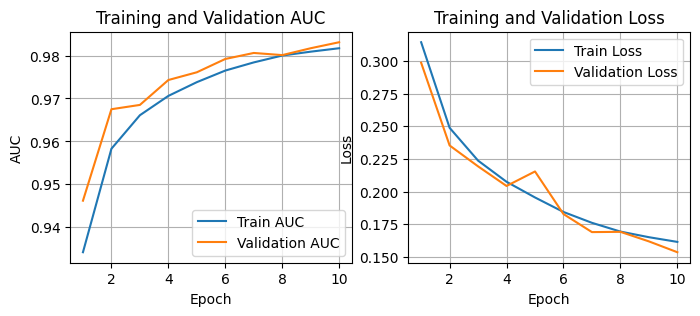

In [ ]:
# Plot training and validation AUC
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11),mymodel_vgg_history_auc, label='Train AUC')
plt.plot(range(1, 11),mymodel_vgg_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 11),mymodel_vgg_history_loss, label='Train Loss')
plt.plot(range(1, 11),mymodel_vgg_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

***
## Conclusion
To be honest, I'm not a professional about this topic.

Task of Imagenet is quite different from this task and I thought features learned in the existing network may not help. But after several attempts, I could get better result via transfer learning.

It would be good to consider which layer should have desirable features for our task.

In [ ]:
df_test = pd.DataFrame({"path": glob.glob(os.path.join(test_img_dir_path, "*.tif"))})
test_X = np.zeros([df_test.shape[0], 96, 96, 3], dtype=np.uint8)

# read images
for i, row in df_test.iterrows():
    test_X[i] = cv2.imread(row['path'])

In [ ]:
# Test data generator
datagen_test = ImageDataGenerator(
    rescale=1./255)

test_generator = datagen_test.flow(test_X, batch_size=64, shuffle=False)
test_predictions = mymodel_vgg.predict(test_generator, verbose=1)

In [ ]:
def get_id(path):
  return os.path.splitext(os.path.basename(path))[0]

test_dict = dict(id= df_test["path"].apply(get_id).to_list(), label= np.where(test_predictions > 0.5, 1, 0).flatten())
test_df = pd.DataFrame.from_dict(test_dict)

In [ ]:
test_df.to_csv("submission.csv", index=False)